In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [14]:
df = pd.read_json ("data/News_Category_Dataset_v3.json" , lines = True)

In [15]:
df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [16]:
CATEGORIES   = ["POLITICS", "TRAVEL", "SPORTS", "HOME & LIVING"]
PER_CLASS    = 1000
RANDOM_STATE = 42

# Filter to 4 categories and keep only short_description + label
df_sub = df[df["category"].isin(CATEGORIES)][["short_description", "category"]].copy()
df_sub = df_sub.rename(columns={"short_description": "text", "category": "label"})

In [17]:
balanced = []
for cat in CATEGORIES:
    sub = df_sub[df_sub["label"] == cat]
    balanced.append(sub.sample(n=PER_CLASS, random_state=RANDOM_STATE))
df_bal = pd.concat(balanced).sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)

df_bal.head()

,text,label
0,Mark Green withdrew his name from consideratio...,POLITICS
1,How To Make It: 1. Cover your lampshade with a...,HOME & LIVING
2,Returns from recent elections demonstrate a se...,POLITICS
3,All you need is a common household item.,HOME & LIVING
4,"No seriously, the angler's name is Guy.",SPORTS


In [18]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df_bal, test_size=0.2, random_state=RANDOM_STATE, stratify=df_bal["label"]
)
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df["label"].value_counts()

Train shape: (3200, 2)
Test shape: (800, 2)


label
TRAVEL           800
SPORTS           800
HOME & LIVING    800
POLITICS         800
Name: count, dtype: int64

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
import numpy as np
import pandas as pd

def top_words_by_category(train_df, categories, top_n):
    """
    Returns: {category: [(word, count), ...]}
    Uses scikit-learn's built-in English stopword list via stop_words='english'.
    """
    vectorizer = CountVectorizer(
        stop_words="english",                      # <-- FIX HERE
        token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b",
        lowercase=True
    )
    result = {}
    for cat in categories:
        texts = train_df.loc[train_df["label"] == cat, "text"].astype(str).tolist()
        X = vectorizer.fit_transform(texts)
        vocab  = np.array(vectorizer.get_feature_names_out())
        counts = np.asarray(X.sum(axis=0)).ravel()
        order  = np.argsort(counts)[::-1]
        result[cat] = list(zip(vocab[order], counts[order]))
    return result

# Rebuild freq dict
freq_dict = top_words_by_category(train_df, CATEGORIES, top_n=100)  # 100 for flexibility
{c: [w for w,_ in freq_dict[c][:10]] for c in CATEGORIES}


{'POLITICS': ['trump',
  'president',
  'said',
  'new',
  'donald',
  'state',
  'people',
  'republican',
  'like',
  'news'],
 'TRAVEL': ['travel',
  'just',
  'world',
  'new',
  'city',
  'time',
  'like',
  'country',
  'people',
  'best'],
 'SPORTS': ['game',
  'said',
  'just',
  'team',
  'time',
  'new',
  'football',
  'sports',
  'world',
  'star'],
 'HOME & LIVING': ['home',
  'just',
  'time',
  'make',
  'say',
  'check',
  'new',
  'like',
  've',
  'day']}

In [21]:
import re

def tokenize_for_overlap(text):
    """
    Lowercase; keep alphabetic tokens (>=2 chars); remove sklearn English stopwords.
    """
    if not isinstance(text, str):
        return set()
    toks = re.findall(r"(?u)\b[a-zA-Z][a-zA-Z]+\b", text.lower())
    return set(t for t in toks if t not in ENGLISH_STOP_WORDS)

def predict_overlap(texts, word_sets, categories):
    """
    Predict by counting overlaps with each category's word set.
    Tie-break: alphabetical among tied categories.
    If no overlaps, fall back to alphabetical first (deterministic).
    """
    preds = []
    cat_sorted = sorted(categories)
    for t in texts:
        toks = tokenize_for_overlap(t)
        overlaps = {c: len(toks & word_sets.get(c, set())) for c in categories}
        max_ov = max(overlaps.values()) if overlaps else 0
        if max_ov == 0:
            chosen = cat_sorted[0]
        else:
            ties = [c for c,v in overlaps.items() if v == max_ov]
            chosen = sorted(ties)[0]
        preds.append(chosen)
    return preds

def accuracy(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    return float((y_true == y_pred).mean())


In [22]:
results = []
for n in [10, 20, 30, 50]:
    word_sets = {c: set([w for w,_ in freq_dict[c][:n]]) for c in CATEGORIES}
    y_true = test_df["label"].tolist()
    y_pred = predict_overlap(test_df["text"].astype(str).tolist(), word_sets, CATEGORIES)
    acc = accuracy(y_true, y_pred)
    results.append({"top_n": n, "accuracy": acc})
    print(f"top_n={n:>2} -> accuracy={acc:.4f}")

res_df = pd.DataFrame(results).sort_values("top_n").reset_index(drop=True)
res_df


top_n=10 -> accuracy=0.3800
top_n=20 -> accuracy=0.4375
top_n=30 -> accuracy=0.4600
top_n=50 -> accuracy=0.5112


,top_n,accuracy
0,10,0.38000
1,20,0.43750
2,30,0.46000
3,50,0.51125


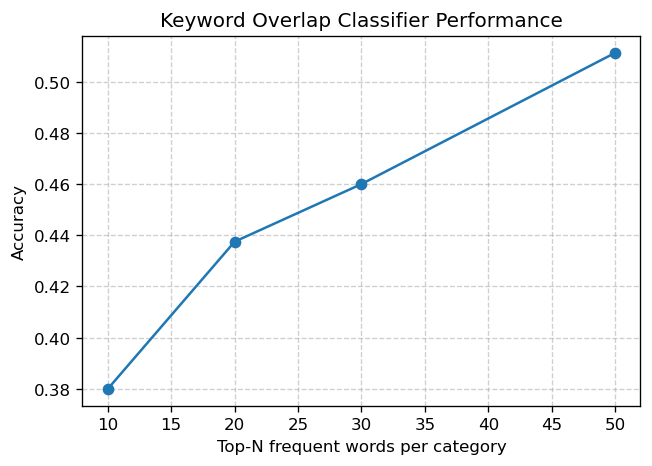

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4), dpi=120)
plt.plot(res_df["top_n"], res_df["accuracy"], marker="o")
plt.xlabel("Top-N frequent words per category")
plt.ylabel("Accuracy")
plt.title("Keyword Overlap Classifier Performance")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [24]:
vectorizer = CountVectorizer(
    stop_words=list(ENGLISH_STOP_WORDS),  # convert frozenset -> list
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b",
    lowercase=True
)


In [25]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


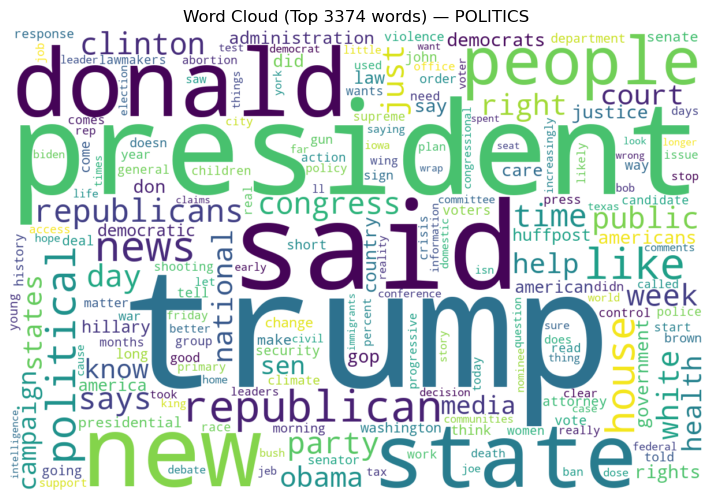

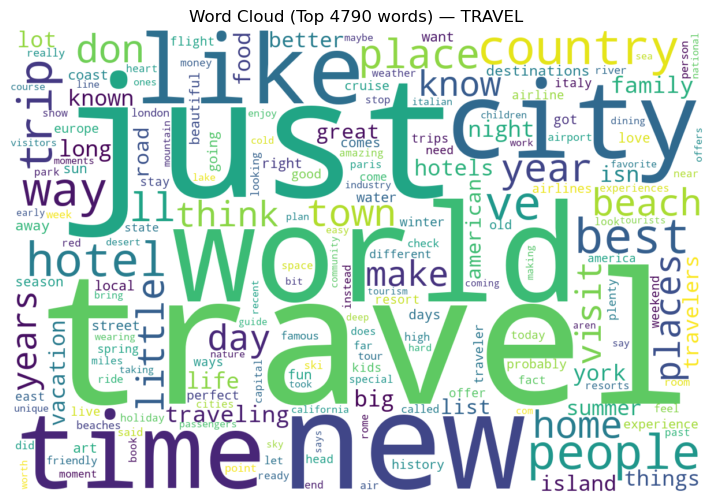

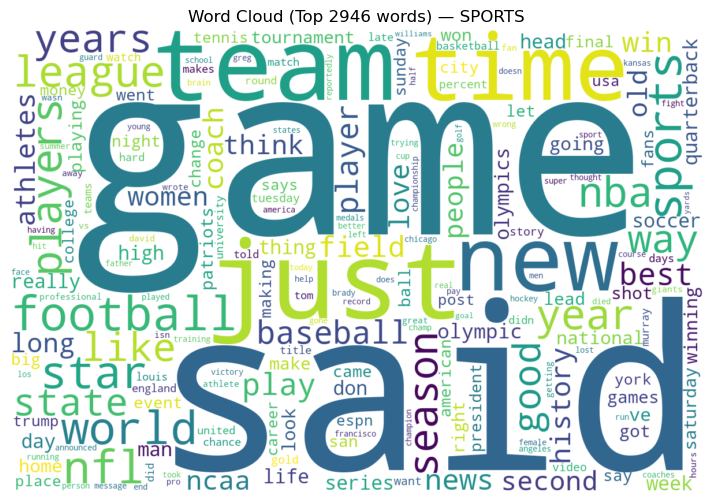

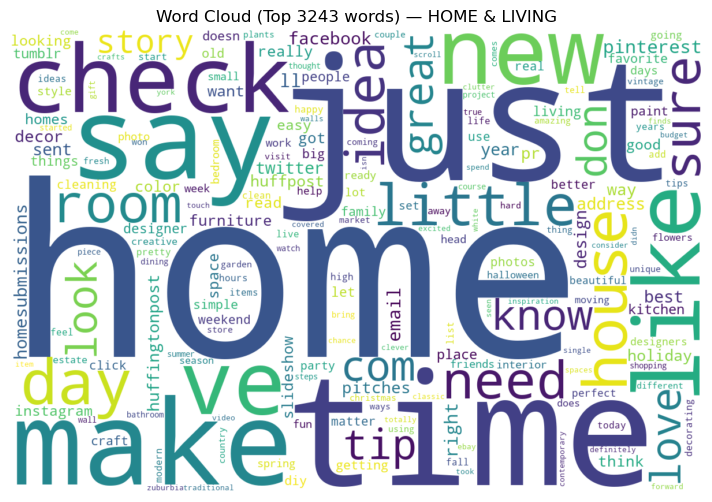

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for each category
for cat, pairs in freq_dict.items():
    freqs = dict(pairs)  # convert [(word, count), ...] to {word: count}
    if not freqs:
        continue
    
    wc = WordCloud(width=1200, height=800, background_color="white")
    wc.generate_from_frequencies(freqs)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud (Top {len(freqs)} words) — {cat}")
    plt.show()
